# Creating Customer Segments

## Project description 

You’ve been hired by a wholesale grocery distributor to help them determine which changes will benefit their business. They recently tested out a change to their delivery method, from a regular morning delivery to a cheaper, bulk evening delivery. Initial tests didn’t discover any significant effect, so they implemented the cheaper option. Almost immediately, they began getting complaints about the change and losing customers. As it turns out, the highest volume customers had an easy time adapting to the change, whereas smaller family run shops had serious issues with it--but these issues were washed out statistically by noise from the larger customers.

For the future, they want to have a sense of what sorts of different customers they have. Then, when implementing changes, they can look at the effects on these different groups independently. Your task is to use unsupervised techniques to see what sort of patterns exist among existing customers, and what exactly makes them different.

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

In [199]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import math 
import matplotlib 
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


## Quick exploratory analysis 

### Summary Statistics

In [18]:
data.describe()

Fresh          Milk       Grocery        Frozen  \
count     440.000000    440.000000    440.000000    440.000000   
mean    12000.297727   5796.265909   7951.277273   3071.931818   
std     12647.328865   7380.377175   9503.162829   4854.673333   
min         3.000000     55.000000      3.000000     25.000000   
25%      3127.750000   1533.000000   2153.000000    742.250000   
50%      8504.000000   3627.000000   4755.500000   1526.000000   
75%     16933.750000   7190.250000  10655.750000   3554.250000   
max    112151.000000  73498.000000  92780.000000  60869.000000   

       Detergents_Paper  Delicatessen  
count        440.000000    440.000000  
mean        2881.493182   1524.870455  
std         4767.854448   2820.105937  
min            3.000000      3.000000  
25%          256.750000    408.250000  
50%          816.500000    965.500000  
75%         3922.000000   1820.250000  
max        40827.000000  47943.000000

### Histograms

The summary statistics above suggest a long tail in the distribution across all variables, which is common in purchase dollar data. The histograms in red below confirmed that this is the case. 

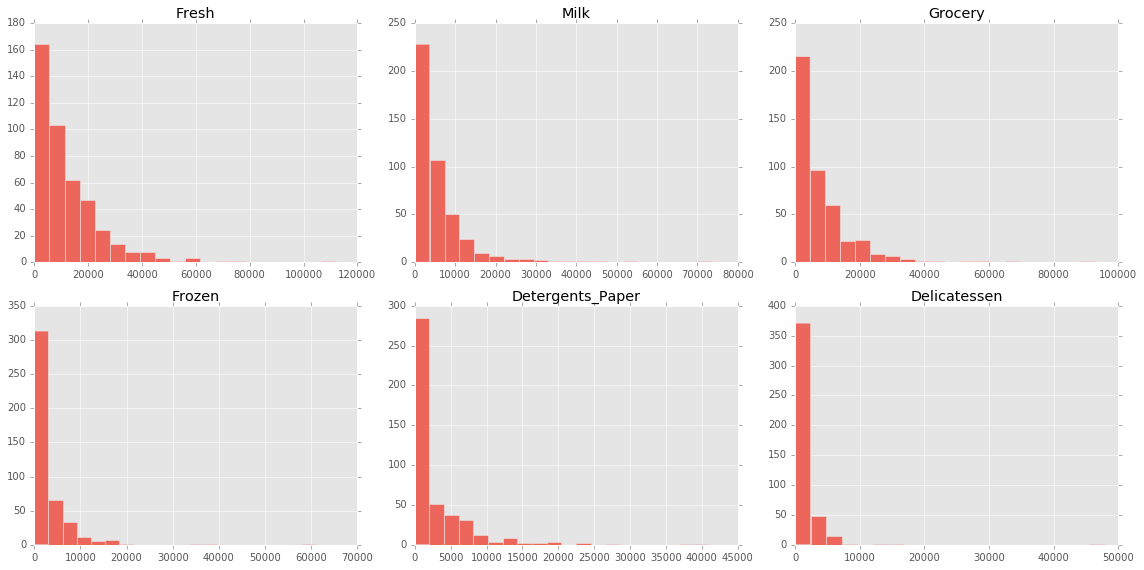

In [195]:
plt.figure(figsize=(16,8))

for i, j in zip(range(6), data.columns):
    plot_no = 231 + i 
    plt.subplot(plot_no)
    plt.hist(data[j], bins=20, color = (0.93,0.4,0.36))
    plt.title(j)

plt.tight_layout()

### Log transformation 

Moreover, even though the variables are on the same scale (i.e. monetary units), the largest variable 'Fresh' is almost one order of magnitude larger than the smallest variable 'Delicatessen' in mean values. While the disparity is not nearly large enough to mandate standardization of variables, we should consider some form of data transformation. In this case, we will perform a log transformation, which not only helps normalize our data, but also bring the values within a closer scale. The histograms below in blue show the transformed data. 

In [196]:
data_log = np.log(data)
df = pd.DataFrame(data_log, columns = data.columns)
df.head()

Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicatessen
0   9.446913  9.175335  8.930759  5.365976          7.891331      7.198931
1   8.861775  9.191158  9.166179  7.474205          8.099554      7.482119
2   8.756682  9.083416  8.946896  7.785305          8.165079      8.967504
3   9.492884  7.086738  8.347827  8.764678          6.228511      7.488853
4  10.026369  8.596004  8.881558  8.272571          7.482682      8.553525

In [197]:
plt.figure(figsize=(16,8))

for i, j in zip(range(6), df.columns):
    plot_no = 231 + i 
    plt.subplot(plot_no)
    plt.hist(df[j], bins=20, color = (0.45,0.62,0.81))
    plt.title('Log of '+ j)

plt.tight_layout()

### Scatterplot and Correlation Matrix

The scatterplot matrix below shows the relationship between each pair of variables. Many variables appear correlated, particularly 'Milk', 'Grocery, and 'Detergents_Paper'.

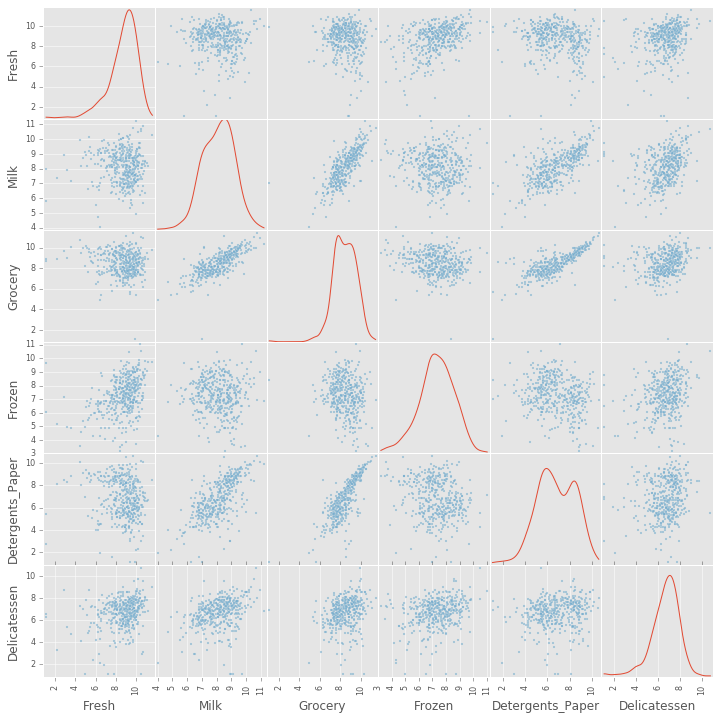

In [201]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(data_log, alpha=.5, figsize=(12, 12), diagonal='kde');

To observe the relationships more precisely, we compute the correlation matrix below. 'Grocery', 'Milk', and 'Detergents_Paper' do indeed have very high pair-wise correlations (all above 0.67). In addition, 'Frozen' and 'Fresh' also have a decently high correlation of 0.38. 'Delicatessen', on the other hand, is weakly correlated with all other items perhaps with the exception of 'Detergents_Paper'. 

In [203]:
df.corr()

Fresh      Milk   Grocery    Frozen  Detergents_Paper  \
Fresh             1.000000 -0.019834 -0.132713  0.383996         -0.155871   
Milk             -0.019834  1.000000  0.758851 -0.055316          0.677942   
Grocery          -0.132713  0.758851  1.000000 -0.164524          0.796398   
Frozen            0.383996 -0.055316 -0.164524  1.000000         -0.211576   
Detergents_Paper -0.155871  0.677942  0.796398 -0.211576          1.000000   
Delicatessen      0.255186  0.337833  0.235728  0.254718          0.166735   

                  Delicatessen  
Fresh                 0.255186  
Milk                  0.337833  
Grocery               0.235728  
Frozen                0.254718  
Detergents_Paper      0.166735  
Delicatessen          1.000000

## Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Answer: Based on our exploratory analysis above, I would guess the first PCA/ICA dimension could be a catch-all term for 'Grocery', 'Milk', and 'Detergents_Paper', which as previously noted, had very high pair-wise correlations. These are likely long shelf-life items that grocery or convenience stores. Another dimension could be a catch-all term for 'Fresh' and 'Frozen' items that also have moderately high correlation. These are highly perishable goods that restaurants or supermarkets are more likely to purchase. Another likely PCA/ICA component could simply be an aggregate of all six purchase categories, a signal of each customer's business scale. 

### PCA

In [209]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
pca_full = PCA(n_components=6)
pca_full.fit(df)

# Print the components and the amount of variance in the data contained in each dimension
print "The PCA components are:"
print pd.DataFrame(pca.components_, columns=df.columns, index=range(1,7)) 
print ""
print "The explained variance ratios are:"
print pca.explained_variance_ratio_

The PCA components are:
      Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicatessen
1 -0.173717  0.394463  0.454364 -0.172196          0.745515      0.149436
2  0.685136  0.162399  0.069379  0.487691          0.041912      0.509709
3  0.673512 -0.033068  0.032183 -0.284811          0.218244     -0.644597
4 -0.214326  0.018558  0.064487  0.806083          0.190050     -0.513490
5  0.000822 -0.722288 -0.347993  0.036243          0.563665      0.195366
6  0.029276 -0.543035  0.813908  0.017448         -0.202444      0.022832

The explained variance ratios are:
[ 0.44237417  0.27657107  0.11617342  0.09617719  0.0457568   0.02294735]


**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

Answer: The majority of the variance is captured by the first two PCA components, accounting for 44% and 28% of the variance respectively. There is a significant drop off after these two components, although the third and fourth PCA components still account for a respectable 12% and 10% variance respectively. This is a relatively tough call: if I were interested in using the PCA components for prediction afterward, I am inclined to include up to 4 dimensions to retain at least 90% of the variance/information. However, during an exploratory analysis stage, I would choose N=2 dimensions for sake of simplicity and ease of interpretation through graphical plots. 

**3)** What do the dimensions seem to represent? How can you use this information?

Answer: As predicted earlier, the first PCA component does appear to be a catch-all term for long shelf-life goods like 'Milk', 'Grocery', and 'Detergents_Paper' that grocery and convenience stores are likely to purchase. The second PCA component, on the other hand, represents more perishable goods like 'Fresh', 'Frozen', and 'Delicatessen'. This information allows us to group our product types into these two broad umbrella categories, thus reducing the dimension of our dataset which in turn allows us to visualize the dataset with our naked eye (which is exceptionally good at recognizing patterns and clusters). The biplot below illustrates the relationship between the original variables and PCA components more clearly: 'Milk', 'Grocery', and 'Detergents_Paper' are very much in the direction of the X-axis (representing PCA1), whereas 'Fresh', 'Frozen', and 'Delicatessen' are more in line with the y-axis (representing PCA2).

In [221]:
pca = PCA(n_components = 2)
pca.fit(df)
xvector = pca.components_[0] 
yvector = pca.components_[1]

xs = pca.transform(df)[:,0] 
ys = pca.transform(df)[:,1]

plt.figure(figsize=(12,12))
plt.xlabel('PCA1')
plt.ylabel('PCA2')

for i in range(len(xvector)):
    plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
              color='r', width=0.0005, head_width=0.0025)
    plt.text(xvector[i]*max(xs)*1.2, yvector[i]*max(ys)*1.2,
             list(data_scaled.columns.values)[i], color='r', size=14)

for i in range(len(xs)):
    plt.plot(xs[i], ys[i], 'bo')

### ICA

In [230]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!

from sklearn.preprocessing import scale 
from sklearn.decomposition import FastICA

df_scaled = pd.DataFrame(scale(data), columns = data.columns)
n_components = 6
ica = FastICA(n_components)
ica.fit(df_scaled)

# Print the independent components
print "The ICA components are:"
print pd.DataFrame(ica.components_, columns=df_scaled.columns, index=range(1, n_components+1))

The ICA components are:
      Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicatessen
1 -0.004906 -0.001408 -0.005717 -0.002358          0.002375      0.050843
2  0.010904  0.001099 -0.007358 -0.054062          0.002603      0.016917
3  0.001882  0.072589 -0.055573 -0.001695          0.016108     -0.017172
4  0.002615 -0.013395  0.062828  0.001871         -0.006135     -0.004468
5  0.050239 -0.006267 -0.006236 -0.003284          0.010097     -0.002933
6  0.003735 -0.017411 -0.113256  0.007112          0.134190      0.016159


**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

Answer: Running ICA with n_components = 6 effectively returns 6 ICA components each driven by one of the original variables. In this case, we see that ICA1 is primarily driven by 'Delicatessen', ICA2 by 'Frozen', ICA3 by 'Milk', ICA4 by 'Grocery', ICA5 by 'Fresh', and finally, ICA6 by 'Detergents_Paper'. ICA is usually used to recover sources from noisy measurements. It is not a suitable method in this case because the data presented are already from 'pure' sources, i.e. purchase amounts in each of the six granular categories. 

## Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

### Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

Answer: K-Means clustering is the more widely used and understood method of the two. Its results are definitive (i.e. hard/unequivocal assignments to clusters) and algorithm is intuitive even for a less sophisticated audience. In cases where there ought to be clear separation of clusters, K-Means clustering ought to suffice. However, in situations that are less clear-cut, such as in this case, when a particular data point could reasonably fall in between two clusters (e.g. a supermarket that sells both shelf-stable grocery goods as well as perishable fresh/frozen goods), Gaussian Mixture Models (GMM) allows for a probablistic, soft assignment of clusters that is more appropriate. The assignment of probabilities is helpful for quantifying uncertainty and works just as well even in cases that warrant hard cluster assignments. As such, GMM is the more flexible method of the two. However, it can also be more computationally intensive, whereas K Means might be a more scalable method. Since we are working with a small dataset, computation time isn't really a concern, and we lean toward GMM for a probabilistic soft clustering. 

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [233]:
# TODO: First we reduce the data to two dimensions using PCA to capture variation
reduced_fit = PCA(n_components=2)
reduced_data = reduced_fit.fit_transform(df)
print reduced_data[:10]  # print upto 10 elements

[[ 1.75098532  0.07051523]
 [ 1.80036534  0.86975357]
 [ 1.89373597  1.67662072]
 [-1.12731297  1.45798229]
 [ 0.79671147  2.46086569]
 [ 1.0838237   0.39294243]
 [ 1.13261002 -0.20160186]
 [ 1.58247377  0.96819642]
 [ 0.87182521 -0.5967589 ]
 [ 2.88888315  0.74110252]]


#### Gaussian Mixture Models

Using BIC, we fitted various combinations of n_components and covariance_type to determine the best parameters for the GMM model. It appears that the spherical model with 3 components yielded the lowest BIC. 

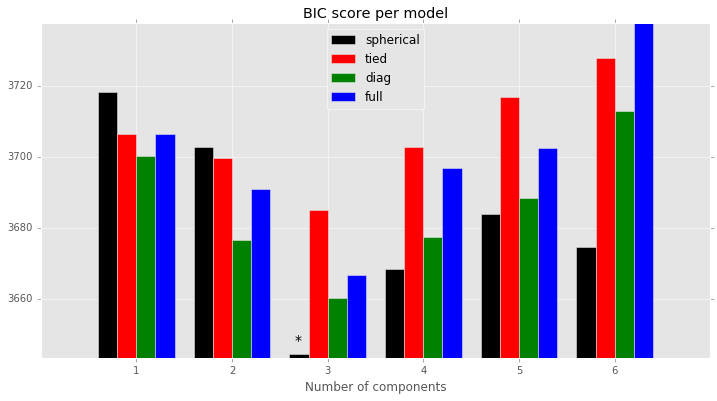

In [247]:
## Use BIC to pick best combination of n_components and covariance_type for the GMM model

from sklearn.mixture import GMM
import itertools

lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a mixture of Gaussians with EM
        gmm = GMM(n_components=n_components, covariance_type=cv_type)
        gmm.fit(reduced_data)
        bic.append(gmm.bic(reduced_data))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['k', 'r', 'g', 'b', 'c', 'm', 'y'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(12,6))
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
plt.xlabel('Number of components')
plt.legend([b[0] for b in bars], cv_types, loc='best')

Below we plotted two models, visualizing the clusters on the reduced dataset along their PCA dimensions, with PCA1 on the x-axis and PCA2 on the y-axis. Both had 'spherical' as the covariance type, but the first model used 3 components/clusters and the second used 4. The 3-component model was the one chosen by BIC, but I didn't think the clusters yielded were immensely informative. The two main cluster were effectively just separate by their PCA1 values, with the third cluster being a catch-all for other stray data points. 

From prior analysis, we saw that PCA2 explained a significant portion of variance in the data. Thus I felt it should be featured more heavily in the clustering than our 3-component model gave it credit for. As such, I decided to move forward with a 4-component spherical model which is more consistent with my intuition (deriving clusters using both PCA dimensions) and also performed relatively well on BIC. 

In [317]:
# Fit both models 

gmm_bic = GMM(n_components=3, covariance_type='spherical')
gmm_final = GMM(n_components=4, covariance_type='spherical')
gmm_bic.fit(reduced_data)
gmm_final.fit(reduced_data)

GMM(covariance_type='spherical', init_params='wmc', min_covar=0.001,
  n_components=4, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

<module 'matplotlib.pyplot' from '/Users/garyng/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

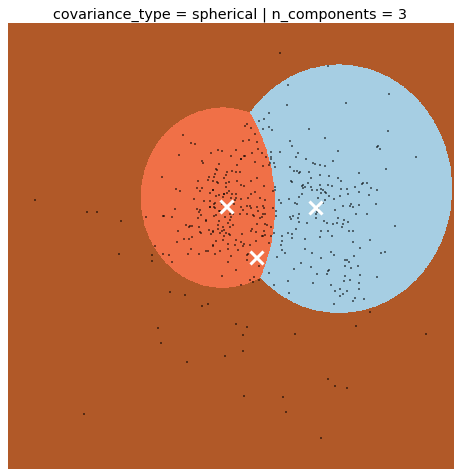

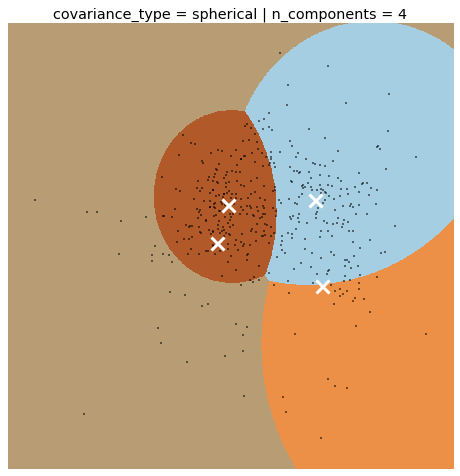

In [318]:
def plotGMM(gmm, n_components, covariance_type): 
    
    # Plot the decision boundary by building a mesh grid to populate a graph.
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    hx = (x_max-x_min)/1000.
    hy = (y_max-y_min)/1000.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = gmm.predict(np.c_[xx.ravel(), yy.ravel()])

    # TODO: Find the centroids for KMeans or the cluster means for GMM 
    centroids = gmm.means_

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8,8))
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('covariance_type = ' + covariance_type + ' | ' 'n_components = ' + str(n_components))
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    
    return plt

plotGMM(gmm_bic, n_components=3, covariance_type='spherical')
plotGMM(gmm_final, n_components=4, covariance_type='spherical')

**7)** What are the central objects in each cluster? Describe them as customers.

The table belows shows the reduced PCA as well as original dimensions of the cluster centers in our chosen model (GMM with covariance_type = spherical and n_components = 4). Our best guesses for the customer identities of each cluster are as follows: 
- Cluster 1 (blue) - large supermarkets (e.g. Whole Foods) that purchase a lot of both fresh perishable goods as well as more shelf-stable products 
- Cluster 3 (orange) - convenience stores that purchase shelf-stable products and home goods but not fresh perishable groceries 
- Cluster 4 (dark brown) - restaurants, delis, farmers' market that primarily purchase fresh perishable food products, but not much of shelf-stable grocery and home products
- Cluster 2 (light brown) - catch-all for other (likely smaller) customers, who generally don't purchase a lot of either type of products

In [324]:
centroids_pca = pd.DataFrame(np.round(gmm_final.means_,1), columns=[['PCA1', 'PCA2']], index=range(1,5))
centroids_original = pd.DataFrame(np.round(np.exp(pca.inverse_transform(gmm_final.means_))), columns=data.columns, index=range(1,5))
pd.concat([centroids_pca, centroids_original], axis=1, join='inner')

PCA1  PCA2  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
1   1.8   0.5   6468  7342    10718    1404              3378          1327
2  -1.8  -0.9   4559  1435     1931    1301               225           380
3   2.0  -2.3    899  5062     9739     341              3537           325
4  -1.4   0.3   9853  2062     2536    2207               322           755

## Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

Answer: PCA was particularly helpful in distilling multiple dimensions of customer data into a couple latent features that could be visualized on a regular graph. This will prove even more useful when dealing with a real-life dataset where there will likely be many more variables to work with. Further, clustering is also very helpful in helping us understand which are our key customer segments, what are their definining characteristics, and how many of them are there in each segment. 

**9)** How would you use that technique to help the company design new experiments?

Answer: In randomized controlled experiments, or A/B testing, the assumption is that we are applying one change (or one set of changes) to otherwise equivalent groups of subjects. In this case, we know that not all customers are alike, thus any results may be influenced by the mix of customers in each group and any positive effects could be masked by Simpson's paradox. In desigining new experiments going forward, the company can do better by conducting separate experiments within each customer segment, thus ensuring that all subjects within the experiment are mostly homogenous and any effects could then be attributed to the experimental change. 

**10)** How would you use that data to help you predict future customer needs?

Answer: Supervised learning techniques such as logistic regression could be employed to understand future customer needs. We could use the PCA analysis above to transform data into one of lower dimension before feeding into these supervised learning techniques. As long as the response variable we are trying to predict is related to the PCA dimensions, using lower-dimension data (that still contains most of the signal) will help improve accuracy in our predictions.  

## References

- https://sukhbinder.wordpress.com/2015/08/05/biplot-with-python/ (creating biplots)
- http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html (GMM model selection with BIC)